# Full Controllability: Falcon-7b

Here we will analyze the results in `ctrl1_falcon7b_*_of_32.csv`. 
 - [ ] Load in all the CSVs, concatenate into 1 big results CSV. 
 - [ ] Plot the portion of uncontrollable instances as a function of $k$. 
 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from ast import literal_eval

# seaborn 
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

In [9]:
def add_zero_prompt_length(df_in): 
    # set prompt_length to zero when base_correct is true 
    df_in.loc[df_in['base_correct'] == True, 'prompt_length'] = 0
    return df_in

In [10]:
def overview_report(df_in): 
    print("Mean prompt correct (epsilon): \t", df_in['prompt_correct'].mean())
    print("Mean prompt correct with k <= 4: ", len(df_in[df_in['prompt_length'] <= 4]) / len(df_in))
    print("Mean base correct: \t\t", df_in['base_correct'].mean())
    print("Mean prompt length: \t\t", df_in['prompt_length'].mean())


In [11]:
def k_epsilon_line_plot(df_in,
                        title="TITLE",
                        output_path=None, 
                        figsize=(6, 4), 
                        log_y=False): 
    # Placeholder for the final percentages
    results = []

    # For each unique question_length
    question_lengths = df_in['question_length'].unique().tolist()
    question_lengths.sort()
    for q_len in question_lengths:
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]

        percentage_correct = []
        prompt_lengths = sorted(temp_df['prompt_length'].unique())
        prompt_lengths = [0] + prompt_lengths
        for p_len in prompt_lengths:
            # Calculate the percentage for this prompt_length
            portion = temp_df[temp_df['prompt_length'] <= p_len]
            correct = portion['prompt_correct'].sum()
            total = len(temp_df)
            percentage = 1-(correct/total)
            percentage_correct.append((p_len, percentage))

        results.append((q_len, percentage_correct))

    # Plotting
    plt.figure(figsize=figsize)

    for q_len, percentages in results:
        x, y = zip(*percentages)
        y = np.array(y)
        plt.plot(x, y, label=f'Question Length {q_len}')

    plt.xlabel('Prompt Length [k]')

    
    
    # logarithmic y-axis 
    if log_y: 
        plt.yscale('log')
        plt.ylabel('Log(Portion Incorrect) [log(epsilon)]')
    else:
        plt.ylabel('Portion Incorrect [epsilon]')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    # plt.yscale('log')
    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    return results


In [12]:
def loss_k_correlation_plots(df_in, 
                             suptitle="TITLE", 
                             output_path=None, 
                             figsize=(8, 9)):
    solved_df = df_in[df_in['prompt_correct'] == 1]
    question_lengths = solved_df['question_length'].unique().tolist()
    question_lengths.sort()

    # make a 3 by 2 grid of plots
    fig, axs = plt.subplots(3, 2, figsize=figsize, sharex=True, sharey=True)
    # sharex and sharey
    print(question_lengths)
    # plot a scatter plot of base_correct vs. prompt_length
    for idx_, q_len in enumerate(question_lengths):
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]
        idx = idx_ + 1
        axs[idx//2, idx%2].scatter(temp_df['base_loss'], temp_df['prompt_length'], alpha=0.5)
        axs[idx//2, idx%2].set_xlabel('Base Loss')
        axs[idx//2, idx%2].set_ylabel('Prompt Length [k]')

        # compute the Pearson correlation coefficient between base_loss and prompt_length
        corr = temp_df['base_loss'].corr(temp_df['prompt_length'])
        print(f'Pearson correlation coefficient (q_len={q_len}): {corr}')
        axs[idx//2, idx%2].set_title(f'Question Len {q_len}: Corr={corr:.2f}')

    # Now we add the overall plot in axs[0,0] 
    axs[0,0].scatter(solved_df['base_loss'], solved_df['prompt_length'], alpha=0.5, c='r')    
    axs[0,0].set_xlabel('Base Loss')
    axs[0,0].set_ylabel('Prompt Length [k]')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])
    axs[0,0].set_title(f'All Question Lengths -- Corr={corr:.2f}')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])

    # tight layout
    plt.suptitle(suptitle)
    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    


In [14]:
def get_prompt_token_freqs(df_in, 
                           tokenizer, 
                           num_to_prompt=20, 
                           title="TITLE", 
                           figsize=(12, 3), 
                           output_path=None): 
    prompt_tokens = df_in[df_in['base_correct'] == False]['best_prompt_ids'].tolist()
    prompt_tokens = [literal_eval(x) for x in prompt_tokens]
    all_prompt_tokens = []
    for x in prompt_tokens: 
        all_prompt_tokens += x
    
    # all_prompt_tokens is a list of all the prompt tokens (including duplicates). 
    # We want to count the number of times each token appears in the list.
    # We can use a dictionary to do this.
    prompt_token_freqs = {}
    for token in all_prompt_tokens:
        if token in prompt_token_freqs:
            prompt_token_freqs[token] += 1
        else:
            prompt_token_freqs[token] = 1

    # now let's sort the dictionary by value
    prompt_token_freqs = {k: v for k, v in sorted(prompt_token_freqs.items(), key=lambda item: item[1], reverse=True)}


    # Let's plot the top 20 tokens
    top_20_tokens = list(prompt_token_freqs.keys())[:num_to_prompt]
    top_20_freqs = list(prompt_token_freqs.values())[:num_to_prompt]

    plt.figure(figsize=figsize)
    plt.bar([i for i in range(num_to_prompt)], top_20_freqs)
    plt.xticks([i for i in range(num_to_prompt)], [tokenizer.decode([x]) for x in top_20_tokens], rotation=90)
    plt.xlabel('Token')
    plt.ylabel('Frequency')
    plt.title(title)

    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, dpi=300)

    return prompt_token_freqs


## Falcon-7b Controllability

In [17]:
# Load in the CSV -- use glob to get all CSVs of the name `ctrl1_falcon7b_*_of_32.csv`
path = r'ctrl1_falcon7b_*_of_32.csv'
all_files = glob.glob(path)
li = []

# Iterate through all files and append to a list
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

# Concatenate all files into one DataFrame
df_falcon_7b = pd.concat(li, axis=0, ignore_index=True)
df

,question,question_ids,answer,answer_ids,base_loss,search_method,best_prompt,best_prompt_ids,prompt_length,prompted_loss,base_correct,prompt_correct,question_length
0,Alive match against Vince McMahon. McMahon wo...,"[45487, 3185, 1542, 41935, 2925, 59803, 204, 2...",listens,44650,15.5625,gcg,Publications,"[56943, 15393, 24, 44650]",4,0.875000,False,True,32
1,. Chris Brown had an additional 19 carries for...,"[204, 25, 7911, 6301, 618, 267, 3149, 204, 660...",comorbid,55019,21.6250,gcg,oko,"[20287, 15332, 216, 62416, 10642, 5710, 50557,...",10,10.937500,False,False,32
2,", 1911 ; however, the route was realigned one ...","[204, 23, 204, 6474, 28, 204, 38, 2537, 204, 2...",astrolog,62267,19.2500,gcg,Inter,"[4122, 59041, 18147, 20289, 48850, 49389]",6,2.218750,False,True,32
3,", which he does, finding a man named Cane Miro...","[204, 23, 585, 332, 960, 204, 23, 4863, 241, 5...",moment,2238,14.0000,gcg,().,"[4753, 29544, 56871, 8897, 285, 1502, 13992, 1...",10,3.203125,False,False,32
4,Lost. The episode sees Boone Carlyle ( Ian So...,"[19375, 204, 25, 390, 6699, 9879, 31693, 42842...",días,21544,23.6250,gcg,palate,"[36525, 5493, 32571, 63630, 29568, 34721, 2879...",10,15.875000,False,False,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,"injury. Hemianopsia, a visual field loss on t...","[5967, 204, 25, 18332, 715, 2379, 494, 204, 23...",geld,31290,17.3750,gcg,Tweet,"[43041, 31290, 8888, 32373, 4219, 12379]",6,0.386719,False,True,16
153,"na no "" ( なの","[2326, 658, 204, 13, 204, 19, 204, 44785, 2469...",notwend,52606,20.0000,gcg,shameless,"[58461, 4378, 35489, 56911, 14976, 17340, 2948...",10,11.375000,False,False,10
154,"NRAO, Charles Moore and Elizabeth Rather form...","[56156, 58, 204, 23, 8776, 14295, 273, 11262, ...",ative,998,17.8750,gcg,ive,"[422, 61385, 64176, 48428, 422, 1119, 21946, 6...",10,7.406250,False,False,22
155,the origin of human life. Series creator Chri...,"[248, 8332, 275, 2079, 1063, 204, 25, 6938, 17...",functioning,15353,15.2500,gcg,to,"[271, 15801, 14730, 562, 24345, 38464, 28840, ...",10,6.718750,False,False,32


In [18]:
overview_report(df_falcon_7b)

Mean prompt correct (epsilon): 	 0.5127388535031847
Mean prompt correct with k <= 4:  0.14251592356687898
Mean base correct: 		 0.0
Mean prompt length: 		 8.297770700636942


In [8]:
# What fraction had base_correct true? 
df['base_correct'].value_counts(normalize=True)

base_correct
False    1.0
Name: proportion, dtype: float64

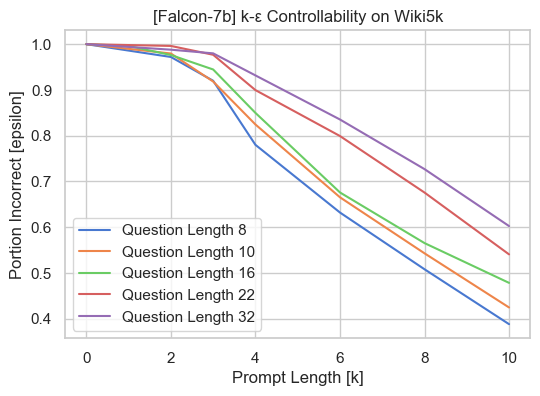

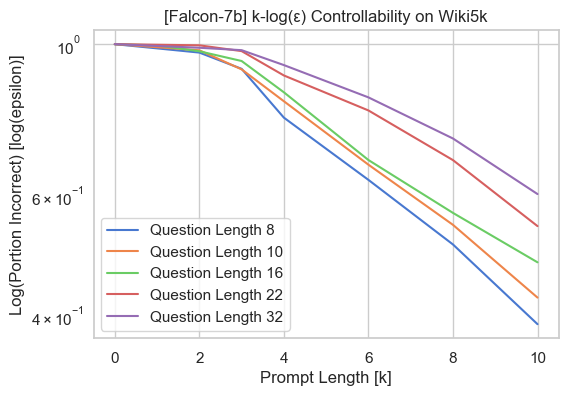

In [20]:
results = k_epsilon_line_plot(df_falcon_7b,
                    title="[Falcon-7b] k-ε Full Controllability on Wiki5k",
                    output_path='line_plot.pdf')


results_log = k_epsilon_line_plot(df_falcon_7b,
                    title="[Falcon-7b] k-log(ε) Full Controllability on Wiki5k",
                    output_path='log_line_plot.pdf',
                    log_y=True)
